In [1]:
#choose model 
import glob
import pandas as pd
datadir = '/home/dmoi/datasets/PPI_antileakage/'
pairs = glob.glob(f'{datadir}*.txt')
dfs = { p.split('/')[-1].split('.txt')[0]: pd.read_csv(p, sep = ' ', header=None, names=['protA', 'protB']) for p in pairs if 'filtered' not in p }
for k in dfs.keys():
	print(k, dfs[k].shape)
#compile non-redundant set of proteins
proteins = set()
for k in dfs.keys():
	proteins = proteins.union( set(dfs[k]['protA'].tolist()) ).union( set(dfs[k]['protB'].tolist()) )
print(f'Number of unique proteins: {len(proteins)}')


Intra2_neg_rr (26024, 2)
Intra1_neg_rr (81596, 2)
Intra2_pos_rr (26024, 2)
Intra0_pos_rr (29630, 2)
Intra0_neg_rr (29630, 2)
Intra1_pos_rr (81596, 2)
Number of unique proteins: 11019


In [2]:

#create a struct folder
folder = '/home/dmoi/datasets/PPI_antileakage/structures/'
import os
if not os.path.exists(folder):
	os.mkdir(folder)

download_structures = False
if download_structures:
	#download structures
	from foldtree2.src import AFDB_tools
	import tqdm
	for struct in tqdm.tqdm(proteins):
		AFDB_tools.grab_struct( struct, folder )

#encode structures

#transformer to weighted set

#weighted jacccard pairise



In [3]:
#check which structures were downloaded
print('Checking downloaded structures...')
#clear filtered csv files
filtered = glob.glob(f'{datadir}*_filtered.txt')
for f in filtered:
	os.remove(f)
#recompile non-redundant set of proteins
print( f'Number of unique proteins to check: {len(proteins)}' )
downloaded = glob.glob(f'{folder}*.pdb')
downloaded = [ d.split('/')[-1].split('.pdb')[0] for d in downloaded ]
print(f'Number of downloaded structures: {len(downloaded)}')
#intersect with proteins
proteins = proteins.intersection( set(downloaded) )
print(f'Number of structures with PDB files: {len(proteins)}')
#filter dfs
for k in dfs.keys():
	print( f'Filtering {k} with {len(proteins)} proteins...' )
	print( k, dfs[k].shape )
	dfs[k] = dfs[k][ dfs[k]['protA'].isin(proteins) & dfs[k]['protB'].isin(proteins) ]
	print(k, dfs[k].shape)
	#add label column
	if 'neg' in k:
		dfs[k]['label'] = 0
	else:
		dfs[k]['label'] = 1
	#add dataset label
	dfs[k]['dataset'] = k.split('_')[0]
	
	#save filtered dfs
	dfs[k].to_csv(f'{datadir}{k}_filtered.txt', sep=' ', header=False, index=False)

#concatenate all filtered dfs
all_pairs = pd.concat( [ dfs[k] for k in dfs.keys() ] )
all_pairs = all_pairs.drop_duplicates().reset_index(drop=True)


Checking downloaded structures...
Number of unique proteins to check: 11019
Number of downloaded structures: 10851
Number of structures with PDB files: 10851
Filtering Intra2_neg_rr with 10851 proteins...
Intra2_neg_rr (26024, 2)
Intra2_neg_rr (25564, 2)
Filtering Intra1_neg_rr with 10851 proteins...
Intra1_neg_rr (81596, 2)
Intra1_neg_rr (77714, 2)
Filtering Intra2_pos_rr with 10851 proteins...
Intra2_pos_rr (26024, 2)
Intra2_pos_rr (25566, 2)
Filtering Intra0_pos_rr with 10851 proteins...
Intra0_pos_rr (29630, 2)
Intra0_pos_rr (29017, 2)
Filtering Intra0_neg_rr with 10851 proteins...
Intra0_neg_rr (29630, 2)
Intra0_neg_rr (28995, 2)
Filtering Intra1_pos_rr with 10851 proteins...
Intra1_pos_rr (81596, 2)
Intra1_pos_rr (77719, 2)


In [4]:
print( all_pairs['label'].value_counts() )
print( all_pairs['dataset'].value_counts() )

valdf = all_pairs[all_pairs['dataset'] == 'Intra0'].sample(frac=0.5).reset_index(drop=True)
traindf = all_pairs[all_pairs['dataset'] == 'Intra1'].sample(frac=0.5).reset_index(drop=True)
testdf = all_pairs[all_pairs['dataset'] == 'Intra2'].sample(frac=0.5).reset_index(drop=True)
print( valdf['label'].value_counts() )
print( traindf['label'].value_counts() )
print( testdf['label'].value_counts() )

label
1    132302
0    132273
Name: count, dtype: int64
dataset
Intra1    155433
Intra0     58012
Intra2     51130
Name: count, dtype: int64
label
0    14590
1    14416
Name: count, dtype: int64
label
1    39051
0    38665
Name: count, dtype: int64
label
1    12795
0    12770
Name: count, dtype: int64


In [5]:
cd /home/dmoi/projects/foldtree2/foldtree2

/home/dmoi/projects/foldtree2/foldtree2


In [6]:
from torch_geometric.data import DataLoader
from foldtree2.src.pdbgraph import PDB2PyG
converter_structures = False
if converter_structures == True:
	converter = PDB2PyG( aapropcsv='./config/aaindex1.csv')
	downloaded = glob.glob(f'{folder}*.pdb')
	#converter.store_pyg(downloaded, filename='structs_pairwise.h5', foldxdir = None, verbose = False)

In [7]:
from foldtree2.src.pdbgraph import StructureDataset
import torch

# Create StructureDataset from the stored PyG file
struct_dat = StructureDataset('structs_pairwise.h5')


In [8]:

# Create a custom loader that yields pairs of encoded structures
class PairwiseStructureLoader:
	def __init__(self, struct_dataset, pairs_df):
		self.struct_dataset = struct_dataset
		self.pairs_df = pairs_df
		# Create mapping from protein ID to dataset index
		self.prot_to_idx = {prot_id: idx for idx, prot_id in enumerate(struct_dataset.structlist)}
	
	def __getitem__(self, idx):
		row = self.pairs_df.iloc[idx]
		prot_a, prot_b = row['protA'], row['protB']
		if prot_a in self.prot_to_idx and prot_b in self.prot_to_idx:
			struct_a = self.struct_dataset[self.prot_to_idx[prot_a]]
			struct_b = self.struct_dataset[self.prot_to_idx[prot_b]]
			y = torch.tensor( row['label'] ) if 'label' in row else None
			return { 'struct_a': struct_a, 'struct_b': struct_b, 'label': y }
		else:
			raise IndexError("Protein ID not found in structure dataset.")

	def __iter__(self):
		for _, row in self.pairs_df.iterrows():
			prot_a, prot_b = row['protA'], row['protB']
			if prot_a in self.prot_to_idx and prot_b in self.prot_to_idx:
				struct_a = self.struct_dataset[self.prot_to_idx[prot_a]]
				struct_b = self.struct_dataset[self.prot_to_idx[prot_b]]
				y = torch.tensor( row['label'] ) if 'label' in row else None
				yield { 'struct_a': struct_a, 'struct_b': struct_b, 'label': y }

	def __len__(self):
		return len(self.pairs_df)


In [9]:


batch_size = 20
# Create loaders for each dataset split
pairwise_loaders = {}
for split_name, split_dfs in [('train', traindf), ('valid', valdf), ('test', testdf)]:
	pairwise_loaders[split_name] = {}
	pairwise_loaders[split_name]['dataset'] = PairwiseStructureLoader(struct_dat, split_dfs)
	print("Pairwise structure loaders created for:")
	print(f"  {split_name}: {len(split_dfs)} pairs")
	#create dataloaders
	pairwise_loaders[split_name]['dataloader'] = DataLoader(pairwise_loaders[split_name]['dataset'], batch_size=batch_size, shuffle=(split_name=='train'), num_workers=4)
	print(f"  Dataloader created with {len(pairwise_loaders[split_name]['dataloader'])} batches")
	print( pairwise_loaders[split_name] )
	
	


Pairwise structure loaders created for:
  train: 77716 pairs
  Dataloader created with 3886 batches
{'dataset': <__main__.PairwiseStructureLoader object at 0x7f7bed207800>, 'dataloader': <torch_geometric.deprecation.DataLoader object at 0x7f7bed351a30>}
Pairwise structure loaders created for:
  valid: 29006 pairs
  Dataloader created with 1451 batches
{'dataset': <__main__.PairwiseStructureLoader object at 0x7f7d25b4dbb0>, 'dataloader': <torch_geometric.deprecation.DataLoader object at 0x7f7bed6956d0>}
Pairwise structure loaders created for:
  test: 25565 pairs
  Dataloader created with 1279 batches
{'dataset': <__main__.PairwiseStructureLoader object at 0x7f7bee2f6660>, 'dataloader': <torch_geometric.deprecation.DataLoader object at 0x7f7bee0b6060>}


/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [10]:
#print a sample from the pairwise loader
for sample in pairwise_loaders['train']['dataloader']:
	print(sample)
	break

{'struct_a': HeteroDataBatch(
  identifier=[20],
  AA={
    x=[16775, 20],
    batch=[16775],
    ptr=[21],
  },
  R_true={
    x=[16775, 3, 3],
    batch=[16775],
    ptr=[21],
  },
  bondangles={
    x=[16775, 3],
    batch=[16775],
    ptr=[21],
  },
  coords={
    x=[16775, 3],
    batch=[16775],
    ptr=[21],
  },
  fourier1di={
    x=[16775, 80],
    batch=[16775],
    ptr=[21],
  },
  fourier1dr={
    x=[16775, 80],
    batch=[16775],
    ptr=[21],
  },
  fourier2di={
    x=[20, 1300],
    batch=[20],
    ptr=[21],
  },
  fourier2dr={
    x=[20, 1300],
    batch=[20],
    ptr=[21],
  },
  godnode={
    x=[20, 5],
    batch=[20],
    ptr=[21],
  },
  godnode4decoder={
    x=[20, 5],
    batch=[20],
    ptr=[21],
  },
  plddt={
    x=[16775, 1],
    batch=[16775],
    ptr=[21],
  },
  positions={
    x=[16775, 256],
    batch=[16775],
    ptr=[21],
  },
  res={
    x=[16775, 857],
    batch=[16775],
    ptr=[21],
  },
  t_true={
    x=[16775, 3],
    batch=[16775],
    ptr=[21],
 

In [11]:
#load encoder model
import torch
import copy
from foldtree2.src import mono_decoders
from foldtree2.src import foldtree2_ecddcd

encoder_modelpath = '/home/dmoi/projects/foldtree2/models/encoder_epoch_90.pt'
decoder_modelpath = '/home/dmoi/projects/foldtree2/models/decoder_epoch_90.pt'
encoder_model = torch.load(encoder_modelpath ,map_location=torch.device('cpu'), weights_only=False)
decoder_model = torch.load(decoder_modelpath ,map_location=torch.device('cpu'), weights_only=False)
print(encoder_model)
print(decoder_model)
modelname = encoder_modelpath.split('/')[-1].split('.pt')[0]
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
encoder_model = encoder_model.to(device)
decoder_model = decoder_model.to(device)
encoder_model.eval()
decoder_model.eval()
model_embeddings = copy.deepcopy(encoder_model.vector_quantizer.embeddings).cpu()

mk1_Encoder(
  (convs): ModuleList(
    (0): ModuleDict(
      (res_contactPoints_res): TransformerConv(200, 200, heads=8)
    )
  )
  (norms): ModuleList(
    (0): GraphNorm(200)
  )
  (bn): BatchNorm1d(857, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.01, inplace=False)
  (jk): JumpingKnowledge(cat)
  (ffin): Sequential(
    (0): Linear(in_features=1017, out_features=400, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=400, out_features=200, bias=True)
    (3): GELU(approximate='none')
  )
  (lin): Sequential(
    (0): Linear(in_features=200, out_features=200, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): GELU(approximate='none')
  )
  (out_dense): Sequential(
    (0): Linear(in_features=220, out_features=200, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): GELU(approximate='none'

In [12]:
#use the encoder to transform the structures to ords 


z1, _  = encoder_model.forward( sample['struct_a'].to(device) )
z2, _  = encoder_model.forward( sample['struct_b'].to(device) )
print( z1, z2 )
#discretize
z1_q , _ = encoder_model.vector_quantizer.discretize_z( z1 )
z2_q , _ = encoder_model.vector_quantizer.discretize_z( z2 )
#embeddings 
print( z1_q , z2_q )
z1_e = encoder_model.vector_quantizer.embeddings(z1_q)
z2_e = encoder_model.vector_quantizer.embeddings(z2_q)
print( z1_e, z2_e )

tensor([[ 0.9910, -1.0000, -0.9978,  ..., -0.9973, -1.0000,  0.9987],
        [ 0.9910, -1.0000, -0.9978,  ..., -0.9973, -1.0000,  0.9987],
        [ 0.7341,  0.8710, -0.8346,  ..., -0.4764,  0.7823, -0.9056],
        ...,
        [ 0.9586,  0.3149, -0.9772,  ..., -0.9296, -0.3285, -0.9295],
        [-0.9800, -1.0000,  0.9672,  ...,  0.9286, -1.0000,  0.9999],
        [ 0.9178,  0.1105, -0.9566,  ..., -0.9012, -0.4044, -0.7979]],
       device='cuda:1', grad_fn=<AddBackward0>) tensor([[ 0.9910, -1.0000, -0.9978,  ..., -0.9973, -1.0000,  0.9987],
        [ 0.9910, -1.0000, -0.9978,  ..., -0.9973, -1.0000,  0.9987],
        [ 0.2297, -1.0000, -0.5692,  ..., -0.8838, -1.0000,  1.0000],
        ...,
        [ 0.9586,  0.3149, -0.9772,  ..., -0.9296, -0.3285, -0.9295],
        [-0.2169,  0.7501,  0.0982,  ...,  0.7878,  0.6859, -0.7125],
        [-0.9878, -0.9379,  0.9865,  ...,  0.9971, -0.9260,  0.8761]],
       device='cuda:1', grad_fn=<AddBackward0>)
tensor([27, 27,  4,  ...,  1, 16, 28

In [13]:
#autoreload
%load_ext autoreload
%autoreload 2

In [14]:
#create the pairwise transformer model
from foldtree2.src import pairwise

hidden_channels = [ 256 , 256 , 256]
out_channels = 32
decoder_hidden = [ 256 , 128  , 64]

pairwise_model = pairwise.signature_transformer(
    encoder=encoder_model, decoder=decoder_model ,  hidden_channels=hidden_channels, out_channels=out_channels, dropout_p=0.005,
    normalize=False,
			  decoder_hidden=decoder_hidden,
              attn_aggregate=False,
			  nheads=8,
			  nlayers=2,
			  seed=42
)

#initialize the model embeddings with the encoder embeddings 
pairwise_model.embeddings = model_embeddings
pairwise_model = pairwise_model.to(device)
pairwise_model.train()

Seed set to 42
/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


signature_transformer(
  (encoder): mk1_Encoder(
    (convs): ModuleList(
      (0): ModuleDict(
        (res_contactPoints_res): TransformerConv(200, 200, heads=8)
      )
    )
    (norms): ModuleList(
      (0): GraphNorm(200)
    )
    (bn): BatchNorm1d(857, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.01, inplace=False)
    (jk): JumpingKnowledge(cat)
    (ffin): Sequential(
      (0): Linear(in_features=1017, out_features=400, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=400, out_features=200, bias=True)
      (3): GELU(approximate='none')
    )
    (lin): Sequential(
      (0): Linear(in_features=200, out_features=200, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=200, out_features=200, bias=True)
      (3): GELU(approximate='none')
    )
    (out_dense): Sequential(
      (0): Linear(in_features=220, out_features=200, bias=True)
      (1): GELU(approximate='none')
      

In [15]:
#forward pass
figurestack = []
reload = False
import glob
if reload == True:
	pairwise_models = glob.glob('models/pairwise_epoch_*.pth')
	if len(pairwise_models) > 0:
		latest_model = max(pairwise_models, key=os.path.getctime)
		print(f"Loading model from {latest_model}")
		pairwise_model = torch.load(latest_model)
def pairloss(preds, labels):
	loss_fn = torch.nn.BCELoss()
	return loss_fn(preds, labels.float())
	

In [16]:
#encode structures
traindfs = { k: dfs[k] for k in dfs.keys() if 'Intra0' in k }
validfs = { k: dfs[k] for k in dfs.keys() if 'Intra1' in k }
testdfs = { k: dfs[k] for k in dfs.keys() if 'Intra2' in k }

In [17]:
cd /home/dmoi/projects/foldtree2/

/home/dmoi/projects/foldtree2


In [ ]:
import tqdm
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Initialize optimizer and scheduler
optimizer = torch.optim.Adam(pairwise_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

# Initialize gradients
optimizer.zero_grad()

# Track running loss for scheduler
running_loss = 0.0
max_epochs = 100
output_auc = True
databreak = 100

encoder_model.eval()

for epoch in range(1, max_epochs + 1):
	running_loss = 0.0
	# Iterate over training data
	#shuffle dataloader each epoch
	#pairwise_loaders['train']['dataloader'] = DataLoader(pairwise_loaders['train']['dataset'], batch_size=16, shuffle=True, num_workers=4)
	for i,data in tqdm.tqdm(enumerate(pairwise_loaders['train']['dataloader'])):
		optimizer.zero_grad()
		data = { k: v.to(device) for k, v in data.items() }
		prot1, prot2 = data['struct_a'], data['struct_b']
		y = data['label'] if data['label'] is not None else None
		with torch.no_grad():
			#forward pass through encoder
			z1, _ = encoder_model( prot1 , None )
			z1discrete , _ = encoder_model.vector_quantizer.discretize_z(z1)
			z1discrete = encoder_model.vector_quantizer.embeddings(z1discrete)
			z2, _ = encoder_model( prot2 , None )
			z2discrete , _ = encoder_model.vector_quantizer.discretize_z(z2)
			z2discrete = encoder_model.vector_quantizer.embeddings(z2discrete)
			prot1['res'].x = z1discrete
			prot2['res'].x = z2discrete
			#pass through decoder to get node features
			z1 = decoder_model( prot1 , None )['z']
			z2 = decoder_model( prot2 , None )['z']
			prot1['zdecoder'].x = z1
			prot2['zdecoder'].x = z2

		sig1 = pairwise_model( prot1 )
		sig2 = pairwise_model( prot2 )
		#torch function sigmoid
		cosine_sim = (pairwise.cosine_similarity(sig1['jaccard_vec'], sig2['jaccard_vec']))
		cosine_sim = torch.sigmoid(cosine_sim)
		#apply sigmoid to jaccard
		loss = pairloss(cosine_sim, y)
		loss.backward()
		# Gradient clipping
		torch.nn.utils.clip_grad_norm_(pairwise_model.parameters(), max_norm=1.0)
		optimizer.step()
		running_loss += loss.item()
		if databreak is not None and i % databreak==0 and i > 0:
			print(f"Databreak at {databreak} batches")
			running_loss /= databreak
			print( 'running loss:', running_loss )
			running_loss = 0.0
			# Save model checkpoint
			#torch.save(pairwise_model, f'models/pairwise_epoch_{epoch}.pth')
			#torch.save(optimizer.state_dict(), f'models/pairwise_optimizer_epoch_{epoch}.pth')
			#run 100 validation batches
			if output_auc == True:
				val_preds = []
				val_labels = []
				pairwise_model.eval()
				with torch.no_grad():
					for j, valdata in enumerate(pairwise_loaders['valid']['dataloader']):
						valdata = { k: v.to(device) for k, v in valdata.items() }
						vprot1, vprot2 = valdata['struct_a'], valdata['struct_b']
						vy = valdata['label'] if valdata['label'] is not None else None
						#forward pass through encoder
						vz1, _ = encoder_model( vprot1 , None )
						vz1discrete , _ = encoder_model.vector_quantizer.discretize_z(vz1)
						vz1discrete = encoder_model.vector_quantizer.embeddings(vz1discrete)

						vz2, _ = encoder_model( vprot2 , None )
						vz2discrete , _ = encoder_model.vector_quantizer.discretize_z(vz2)
						vz2discrete = encoder_model.vector_quantizer.embeddings(vz2discrete)

						vprot1['res'].x = vz1discrete
						vprot2['res'].x = vz2discrete
						
						z1 = decoder_model( vprot1 , None )['z']
						z2 = decoder_model( vprot2 , None )['z']

						vprot1['zdecoder'].x = z1
						vprot2['zdecoder'].x = z2

						vsig1 = pairwise_model( vprot1 )
						vsig2 = pairwise_model( vprot2 )
						
						#torch function sigmoid
						vcosine_sim = (pairwise.cosine_similarity(vsig1['jaccard_vec'], vsig2['jaccard_vec']))
						vcosine_sim = torch.sigmoid(vcosine_sim)
						val_preds.extend( vcosine_sim.cpu().numpy().tolist() )
						val_labels.extend( vy.cpu().numpy().tolist() )
						if j >= 100:
							break
				val_auc = roc_auc_score(val_labels, val_preds)
				#plot roc curve
				plt.figure()
				from sklearn.metrics import RocCurveDisplay
				RocCurveDisplay.from_predictions(val_labels, val_preds)
				plt.title(f'Validation ROC after epoch {epoch}, batch {i}: AUC={val_auc:.4f}')
				plt.show()
				print(f"Validation AUC after epoch {epoch}, batch {i}: {val_auc}")
				pairwise_model.train()

100it [05:06,  3.00s/it]

Databreak at 100 batches
running loss: 0.7285953152179718


100it [07:11,  4.31s/it]


NameError: name 'plt' is not defined

In [ ]:
#find auc on validation set
pairwise_model.eval()
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot as plt
val_labels = []
val_preds = []
valbreak = 500
with torch.no_grad():	
	for i,data in tqdm.tqdm(enumerate(pairwise_loaders['valid']['dataloader'])):
		data = { k: v.to(device) for k, v in data.items() }
		prot1, prot2 = data['struct_a'], data['struct_b']
		y = data['label'] if data['label'] is not None else None
		#forward pass through encoder
		z1, _ = encoder_model( prot1 , None )
		z1discrete , _ = encoder_model.vector_quantizer.discretize_z(z1)
		z2, _ = encoder_model( prot2 , None )
		z2discrete , _ = encoder_model.vector_quantizer.discretize_z(z2)
		prot1['zdiscrete'].x = z1discrete
		prot2['zdiscrete'].x = z2discrete
		sig1 = pairwise_model( prot1 )
		sig2 = pairwise_model( prot2 )
		jaccard = pairwise.weighted_jaccard_similarity(sig1['jaccard_vec'], sig2['jaccard_vec'])
		val_labels.extend( y.cpu().numpy().tolist() )
		val_preds.extend( jaccard.cpu().numpy().tolist() )
		if i > valbreak:
			print(f"Validation break at {valbreak} batches")
			break


501it [03:42,  2.25it/s]

Validation break at 500 batches


: 

: 

: 

: 

: 

: 

: 

In [ ]:
print( len(val_labels), len(val_preds) )
#show histogram of predictions
plt.hist( val_preds, bins=50 )
plt.xlabel('Predicted Jaccard Similarity')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Jaccard Similarities on Validation Set')
plt.show()

1515 1515


NameError: name 'plt' is not defined

6 15


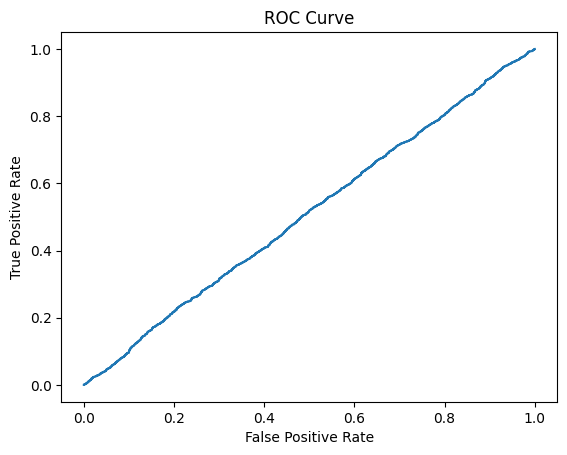

Validation AUC: 0.5099828014461205


: 

: 

: 

: 

: 

: 

In [ ]:

print( sum( y.cpu().numpy().tolist() )  , len(y.cpu().numpy().tolist())  )
roc_curves = roc_curve(val_labels, val_preds)
plt.plot(roc_curves[0], roc_curves[1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
val_auc = roc_auc_score(val_labels, val_preds)
print(f"Validation AUC: {val_auc}")
scheduler.step(val_auc)


In [ ]:
#train the model for pairwise

from foldtree2.src import pairwise





: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
#pr and roc

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
#compare to hashed jaccard 

#pr and roc

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 